In [21]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rapids-21.12


In [22]:
import sys

dir_github = r'/media/rich/Home_Linux_partition/github_repos/'
# sys.path.append('/n/data1/hms/neurobio/sabatini/rich/github_repos/')
sys.path.append(dir_github)

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from pathlib import Path
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm
from functools import partial

In [24]:
dir_stats = Path(r'/media/rich/bigSSD/other lab data/Takesian_lab/Suite2p masks for Rich').resolve()

In [25]:
from glob import glob
paths_stats = list(dir_stats.glob('**/*stat*.npy'))
paths_stats

[PosixPath('/media/rich/bigSSD/other lab data/Takesian_lab/Suite2p masks for Rich/NDNF/NxDB092719M2/FOV3 Day 1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Takesian_lab/Suite2p masks for Rich/NDNF/NxDB092719M2/FOV3 Day 2/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Takesian_lab/Suite2p masks for Rich/NDNF/NxDB092719M2/FOV4/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Takesian_lab/Suite2p masks for Rich/NDNF/NxDC030220F2/FOV1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Takesian_lab/Suite2p masks for Rich/NDNF/NxDC030220F2/FOV2/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Takesian_lab/Suite2p masks for Rich/NDNF/NxDC030220M3/FOV1 Day 1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Takesian_lab/Suite2p masks for Rich/NDNF/NxDC030220M3/FOV2 Day 1/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Takesian_lab/Suite2p masks for Rich/NDNF/NxDC030220M3/FOV3/stat.npy'),
 PosixPath('/media/rich/bigSSD/other lab

In [26]:
len(paths_stats)

74

In [27]:
stats = [np.load(path, allow_pickle=True) for path in tqdm(paths_stats)]

  0%|          | 0/74 [00:00<?, ?it/s]

In [28]:
def statFile_to_spatialFootprints(path_statFile=None, statFile=None, out_height_width=[36,36], max_footprint_width=241, plot_pref=True, one_indexed=False, dtype=np.float32):
    """
    Converts a stat file to a list of spatial footprint images.
    RH 2021

    Args:
        path_statFile (pathlib.Path or str):
            Path to the stat file.
            Optional: if statFile is provided, this
             argument is ignored.
        statFile (dict):
            Suite2p stat file dictionary
            Optional: if path_statFile is provided, this
             argument is ignored.
        out_height_width (list):
            [height, width] of the output spatial footprints.
        max_footprint_width (int):
            Maximum width of the spatial footprints.
        plot_pref (bool):
            If True, plots the spatial footprints.
    
    Returns:
        sf_all (list):
            List of spatial footprints images
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    assert out_height_width[0]%2 == 0 and out_height_width[1]%2 == 0 , "RH: 'out_height_width' must be list of 2 EVEN integers"
    assert max_footprint_width%2 != 0 , "RH: 'max_footprint_width' must be odd"
    if statFile is None:
        stat = np.load(path_statFile, allow_pickle=True)
    else:
        stat = statFile
        
    if one_indexed:
        idx_offset = -1
    else:
        idx_offset = 0
    
    n_roi = len(stat)
    
    # sf_big: 'spatial footprints' prior to cropping. sf is after cropping
    sf_big_width = max_footprint_width # make odd number
    sf_big_mid = sf_big_width // 2

    sf_big = np.zeros((n_roi, sf_big_width, sf_big_width), dtype=dtype)
    for ii in range(n_roi):
        sf_big[ii , stat[ii]['ypix'] - np.int16(stat[ii]['med'][0]) + sf_big_mid + idx_offset, stat[ii]['xpix'] - np.int16(stat[ii]['med'][1]) + sf_big_mid + idx_offset] = stat[ii]['lam'] # (dim0: ROI#) (dim1: y pix) (dim2: x pix)

    sf = sf_big[:,  
                sf_big_mid - out_height_width[0]//2:sf_big_mid + out_height_width[0]//2,
                sf_big_mid - out_height_width[1]//2:sf_big_mid + out_height_width[1]//2]
    if plot_pref:
        plt.figure()
        plt.imshow(np.max(sf, axis=0)**0.2)
        plt.title('spatial footprints cropped MIP^0.2')
    
    return sf

In [29]:
def import_and_convert_to_CellReg_spatialFootprints(
    paths_statFiles=None, 
    statFiles=None,
    frame_height=512, 
    frame_width=1024,
    dtype=np.float32,
    ):
    """
    Imports and converts multiple stat files to spatial footprints
     suitable for CellReg.
    Output will be a list of arrays of shape (n_roi, height, width).
    RH 2022
    """

    isInt = np.issubdtype(dtype, np.integer)

    if paths_statFiles is not None:
        stats = [np.load(path, allow_pickle=True) for path in paths_statFiles]
    else:
        stats = statFiles
    
    num_rois = [len(stat) for stat in stats]
    
    if frame_height is None:
        print('calculating frame shapes automatically')
        sf_max_idx = np.array([np.max([np.array([roi['ypix'].max(), roi['xpix'].max()]) for roi in stat], axis=0) for stat in tqdm(stats)])
#         sf_min_idx = np.array([np.min([np.array([roi['ypix'].max(), roi['xpix'].max()]) for roi in stat], axis=0) for stat in tqdm(stats)])
        frame_shapes = 2**np.ceil(np.log(sf_max_idx+1) / np.log(2)).astype(np.int64)
        sf_all_list = [np.zeros((n_roi, frame_shapes[ii][0], frame_shapes[ii][1]), dtype) for ii, n_roi in enumerate(tqdm(num_rois))]
    
    else:
        sf_all_list = [np.zeros((n_roi, frame_height, frame_width), dtype) for n_roi in num_rois]
        
    for ii, stat in enumerate(tqdm(stats)):
        for jj, roi in enumerate(stat):
            lam = np.array(roi['lam'])
            if isInt:
                lam = dtype(lam / lam.sum() * np.iinfo(dtype).max)
            else:
                lam = lam / lam.sum()
            sf_all_list[ii][jj, roi['ypix'], roi['xpix']] = lam
    return sf_all_list

## Duplicates analysis (optional)
run below line only to skip

In [49]:
idx_to_keep_all = np.arange(len(stats))

In [31]:
sfFOVs = import_and_convert_to_CellReg_spatialFootprints(
    paths_statFiles=None, 
    statFiles=stats,
#     frame_height=2048, 
#     frame_width=2048,
    frame_height=None, 
    frame_width=None,
    dtype=np.float32,
)

calculating frame shapes automatically


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


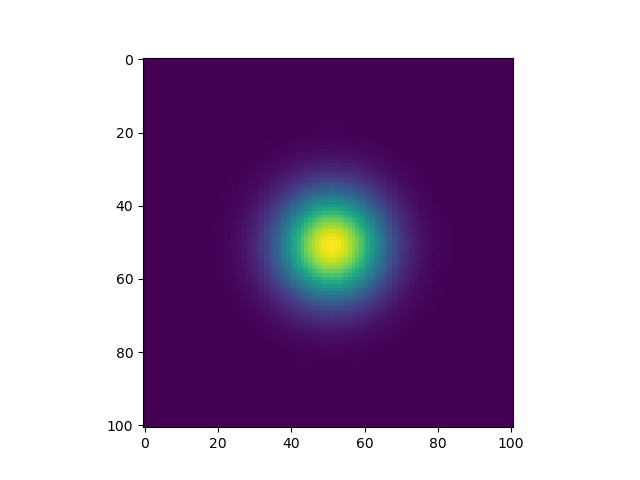

In [69]:
gaus = featurization.gaussian_kernel_2D(center = (51, 51), image_size = (101, 101), sig = 10)

plt.figure()
plt.imshow(gaus)

In [70]:
import torch
def torch_conv2d(img, kernel):
    return torch.nn.functional.conv2d(img[None,None,...], kernel[None,None,...], bias=None, stride=1, padding='same', dilation=1, groups=1)

In [71]:
def helper_max(arr_ii):
    if arr_ii[1] % 10 == 0:
        print(arr_ii[1])
    return np.max(arr_ii[0], axis=0)

FOVs_max = parallel_helpers.multithreading(helper_max, [(sfFOV, ii) for ii, sfFOV in enumerate(sfFOVs)], workers=36)

0
10
20
30
40
50
60
70


In [72]:
FOVs_conv = [torch_conv2d(torch.as_tensor(FOV, dtype=torch.float32, device='cuda:0'), torch.as_tensor(gaus, dtype=torch.float32, device='cuda:0')).cpu().numpy().squeeze() for FOV in tqdm(FOVs_max)]

  0%|          | 0/74 [00:00<?, ?it/s]

In [73]:
bin_widths = [8,8]
pad_size = np.max([int(np.ceil(np.prod(FOV.shape)/(bin_widths[0]*bin_widths[1]))) for FOV in FOVs_conv])
def helper_pad(vec, pad_len):
    out = np.zeros(pad_len, dtype=np.float32)
    out[:len(vec)] = vec
    return out
FOVs_conv_flat = np.array([helper_pad(image_processing.bin_array(FOV, bin_widths=[8,8], method='post_crop').reshape(-1), pad_size) for FOV in tqdm(FOVs_conv)])

  0%|          | 0/74 [00:00<?, ?it/s]

In [74]:
FOVs_conv_flat.shape

(74, 4096)

In [75]:
import umap 

umap_obj = umap.UMAP(    
    n_neighbors=4,
    n_components=1,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

In [76]:
embedding = umap_obj.fit_transform(FOVs_conv_flat)

<IPython.core.display.Javascript object>


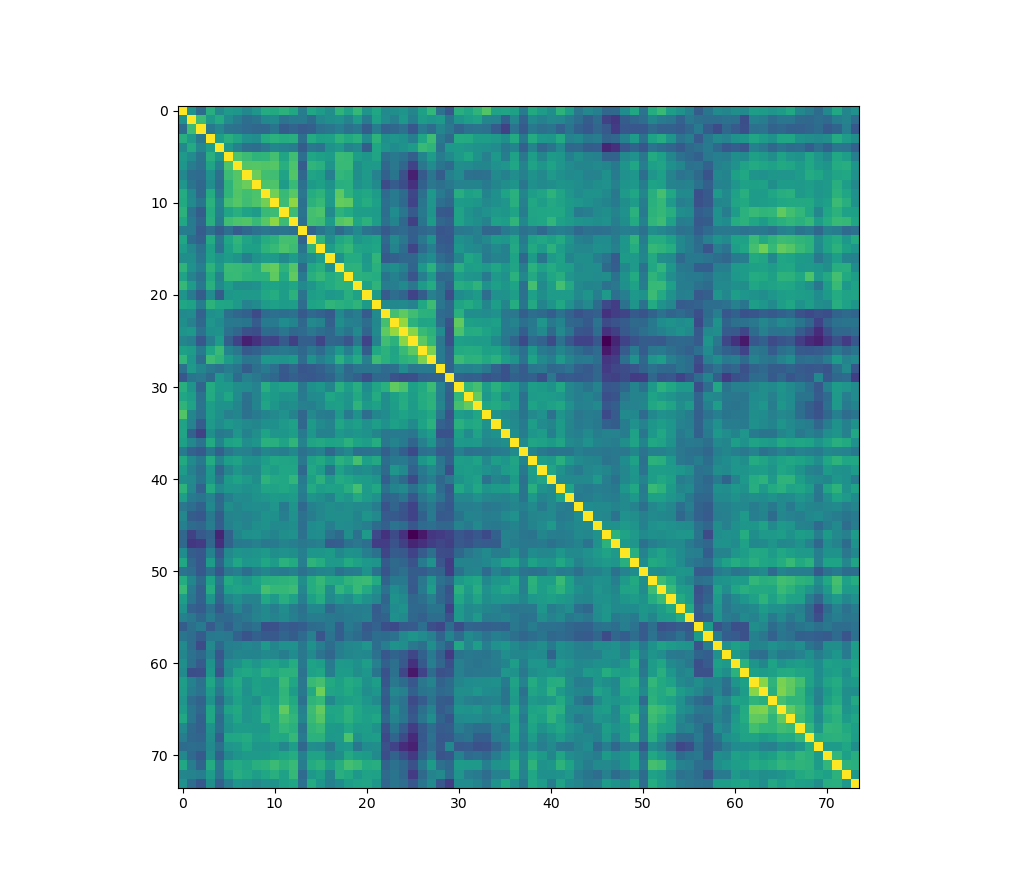

In [77]:
plt.figure()
plt.imshow(similarity.pairwise_similarity(FOVs_conv_flat.T[:, np.argsort(embedding.squeeze())]))

<IPython.core.display.Javascript object>


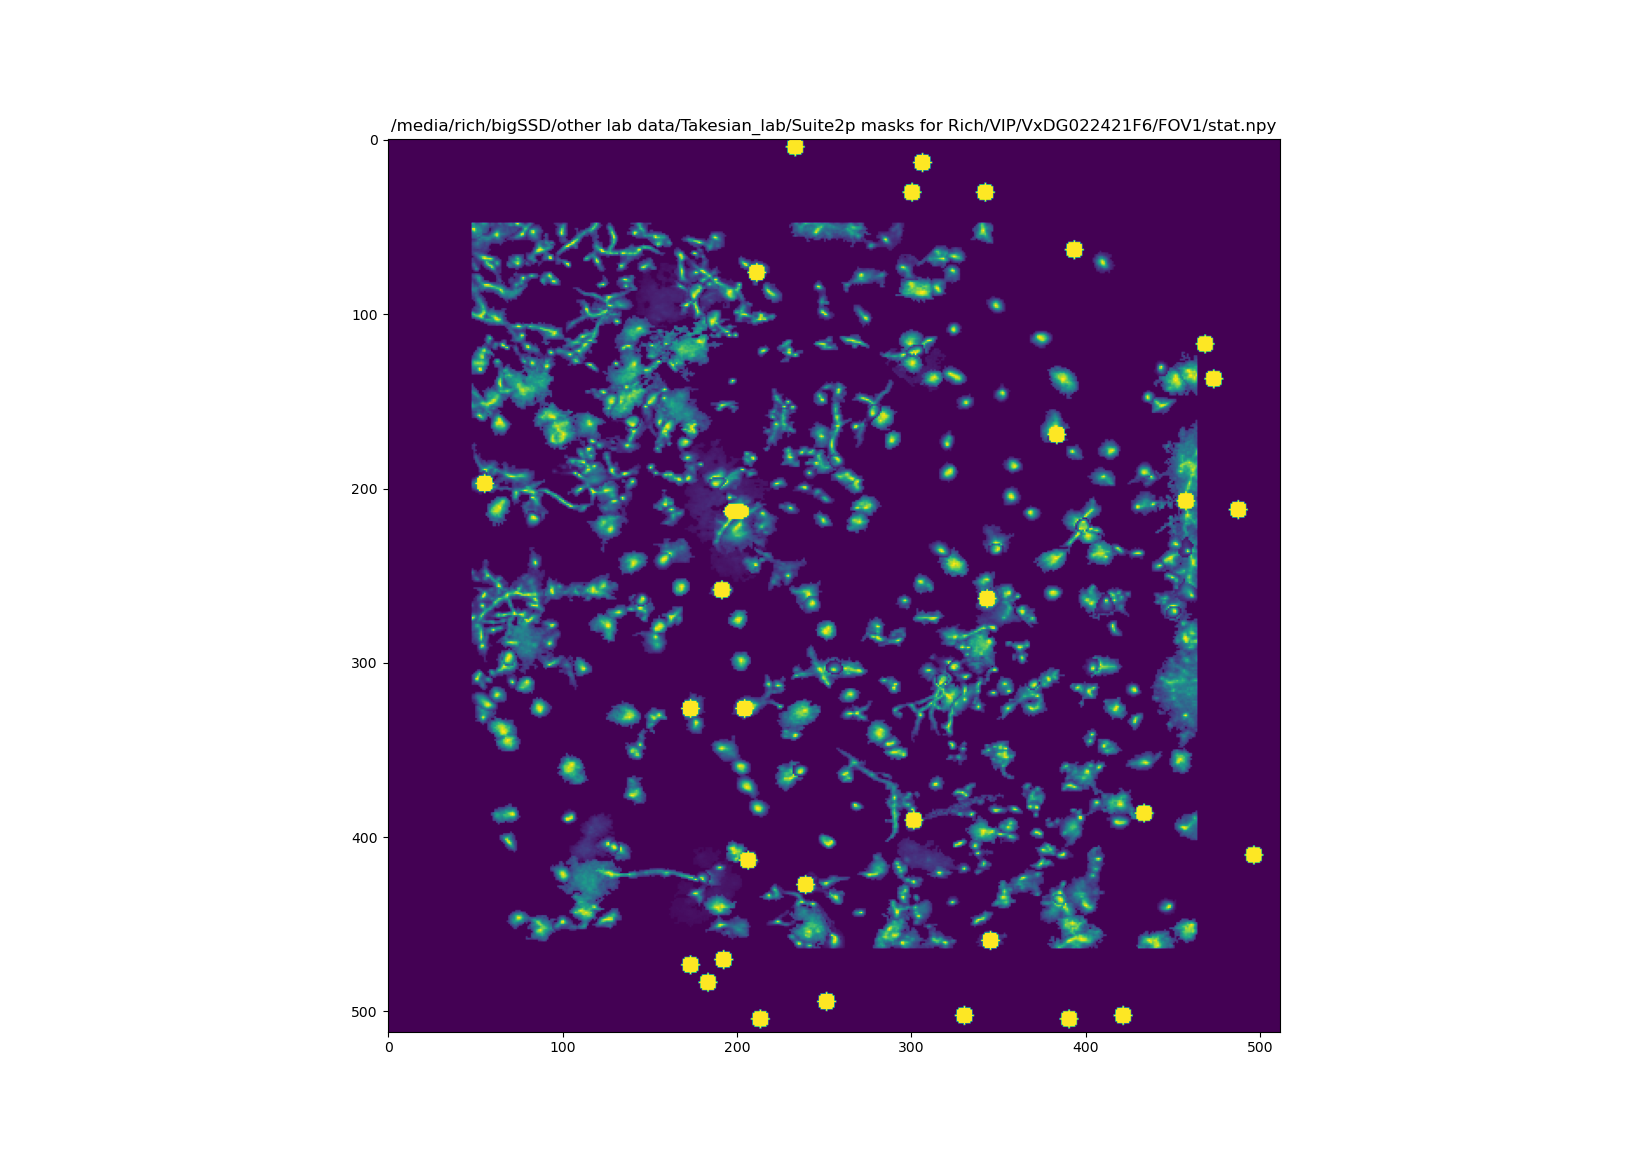

interactive(children=(IntSlider(value=0, description='i_frame', max=73), Output()), _dom_classes=('widget-inte…

In [83]:
plotting_helpers.display_toggle_image_stack(np.array(FOVs)[ np.argsort(embedding.squeeze())], labels=paths_stats)

In [ ]:
6,8,9,10,22,23,27,29,62

In [42]:
sim = similarity.pairwise_similarity(FOVs_conv_flat.T)

<IPython.core.display.Javascript object>


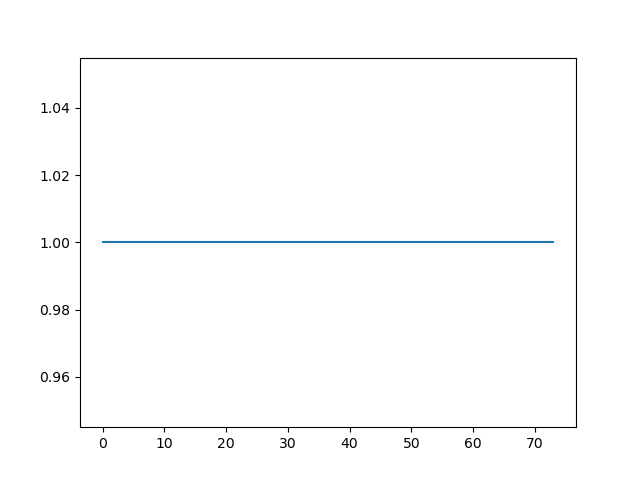

In [43]:
plt.figure()
plt.plot((sim>0.999999).sum(1))

<IPython.core.display.Javascript object>


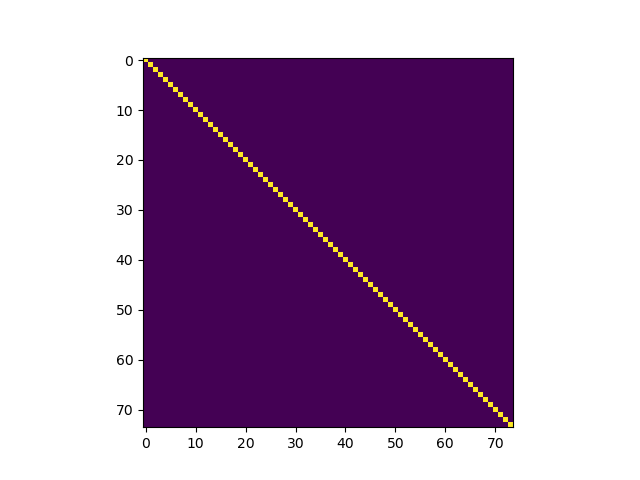

In [44]:
plt.figure()
plt.imshow(sim*(sim>0.999))

In [45]:
thresh = 0.99

sim_temp = (sim > thresh) * np.logical_not(np.eye(sim.shape[0]))

idx_to_del_all = []
idx_to_keep_all = np.arange(sim_temp.shape[0])
while (sim_temp > thresh).sum() > 0:
    idx_with_dups = (sim_temp > thresh).sum(1) > 0

    idx_to_del = sim_temp[idx_with_dups[0]] > 0
    
    idx_with_dups, idx_to_del_gross = np.nonzero(sim_temp > thresh)
    
    idx_to_del = idx_to_del_gross[0]
#     idx_to_keep = np.concatenate((np.arange(0, idx_to_del), np.arange(idx_to_del+1, sim_temp.shape[0])))
#     sim_temp = sim_temp[idx_to_keep, :]
#     sim_temp = sim_temp[:, idx_to_keep]
    sim_temp = np.delete(sim_temp, idx_to_del, axis=0)
    sim_temp = np.delete(sim_temp, idx_to_del, axis=1)
    
    idx_to_del_all.append(idx_to_keep_all[idx_to_del])
    
    idx_to_keep_all = np.delete(idx_to_keep_all, idx_to_del, axis=0)

In [46]:
sim_temp.shape

(74, 74)

In [47]:
sim2 = copy.copy(sim)
sim2 = np.delete(sim2, np.array(idx_to_del_all), axis=0)
sim2 = np.delete(sim2, np.array(idx_to_del_all), axis=1)

IndexError: arrays used as indices must be of integer (or boolean) type

<IPython.core.display.Javascript object>


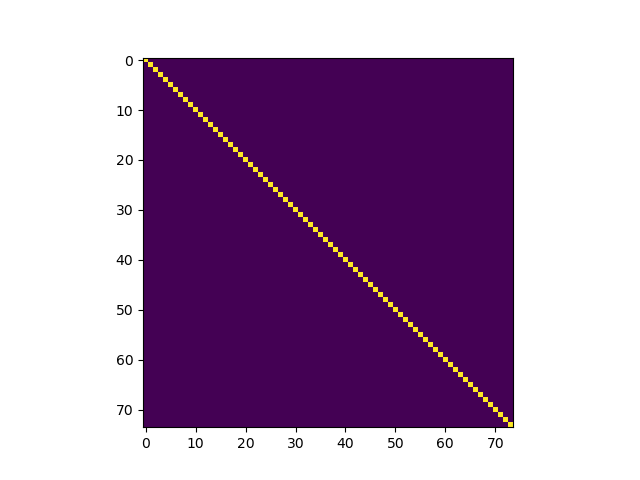

In [48]:
plt.figure()
# plt.imshow(sim_temp>0.99)
plt.imshow(sim2>0.99)

## OPTIONAL (start)

In [62]:
def sf_to_FOV(sfs, eps=1e-20):

#     FOV = copy.copy(sfs)
    FOV = sfs / (sfs.max((1,2), keepdims=True) + eps)
    FOV = FOV.max(0)
    return FOV

In [64]:
FOVs = [sf_to_FOV(sf) for sf in tqdm(sfFOVs)]

  0%|          | 0/74 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


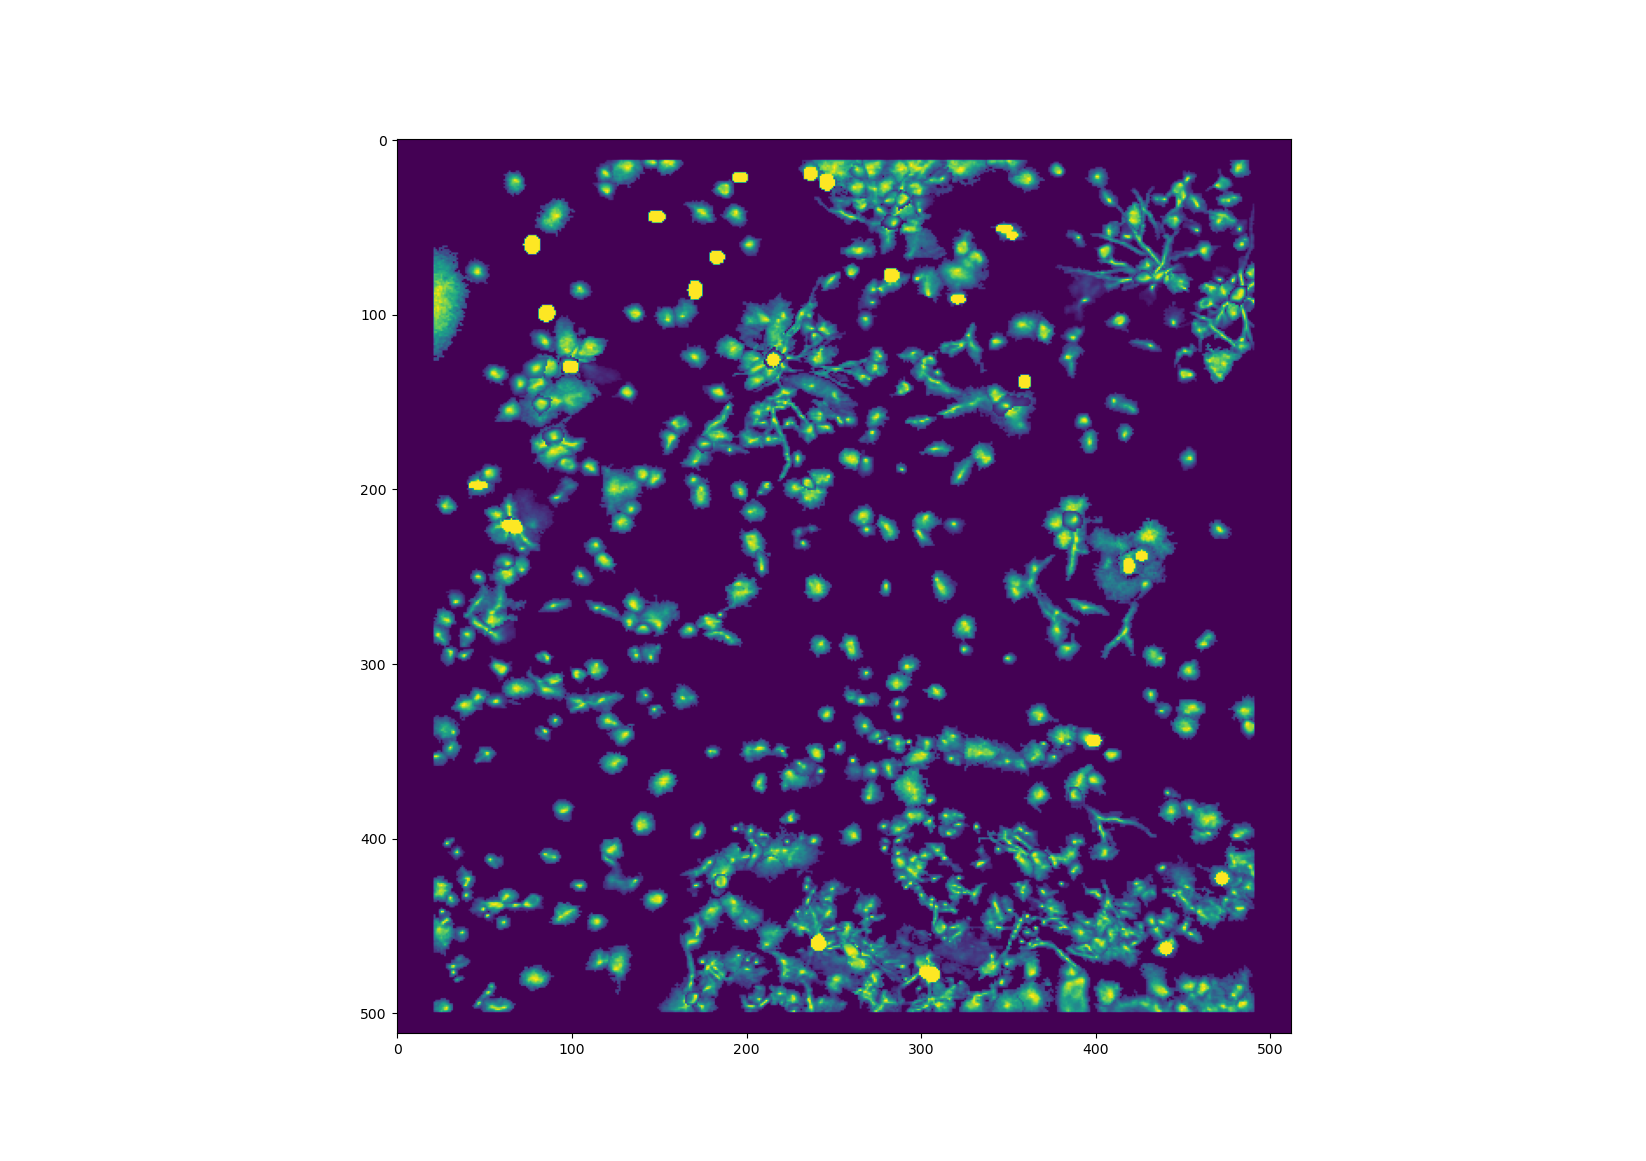

interactive(children=(IntSlider(value=0, description='i_frame', max=73), Output()), _dom_classes=('widget-inte…

In [66]:
plotting_helpers.display_toggle_image_stack(FOVs)

<IPython.core.display.Javascript object>


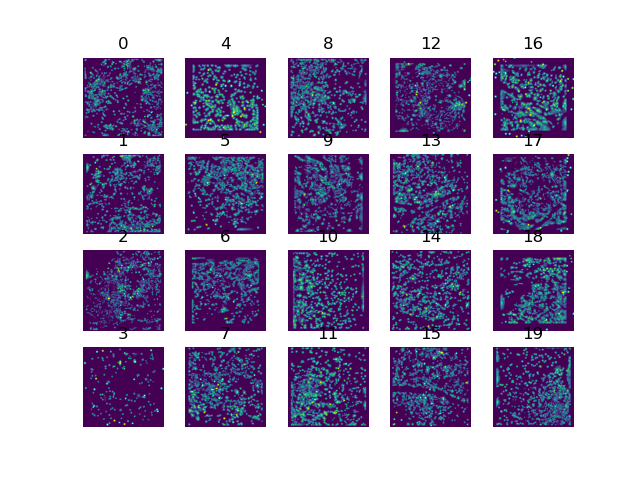

(<Figure size 640x480 with 20 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'4'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'16'}>],
        [<AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'9'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'17'}>],
        [<AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'14'}>,
         <AxesSubplot:title={'center':'18'}>],
        [<AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'11'}>,
         <AxesSubplot:title={'center':'15'}>,
         <AxesSubplot:title={'center':'19'}>]], dtype=object))

In [65]:
%matplotlib notebook

plotting_helpers.plot_image_grid(
    images = FOVs,
    grid_shape = (4, 5),
    labels = range(0,len(FOVs))
)

## OPTIONAL (end)

In [84]:
bad_sessions = [6,8,9,10,22,23,27,29,62]
n_sessions = len(stats)
good_sessions = np.arange(n_sessions)
good_sessions = np.array(good_sessions[np.isin(good_sessions, bad_sessions, invert=True)])

# good_sessions = idx_to_keep_all

In [85]:
sf_all = [
    statFile_to_spatialFootprints(
        statFile=stat, 
        out_height_width=[36,36],
        max_footprint_width=1441, 
        plot_pref=False, 
        one_indexed=True,
        dtype=np.float32
    ) for stat in tqdm(np.array(stats, dtype=object)[good_sessions])
]

  0%|          | 0/65 [00:00<?, ?it/s]

In [92]:
sf_concat_all = np.concatenate(sf_all, axis=0)

<IPython.core.display.Javascript object>


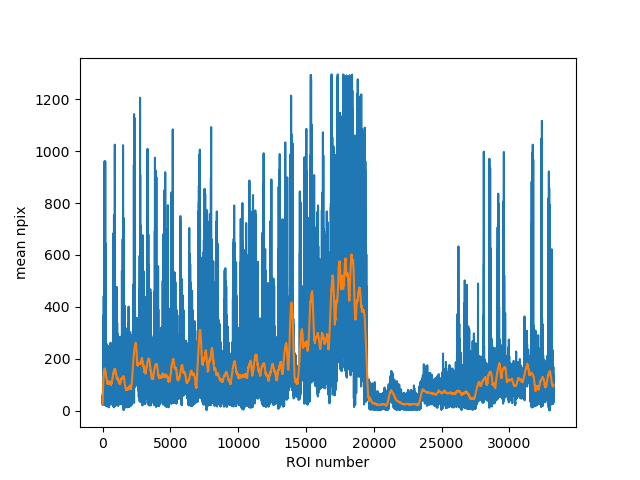

In [95]:
%matplotlib notebook

plt.figure()
plt.plot(np.sum(sf_concat_all > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(sf_concat_all > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

<IPython.core.display.Javascript object>


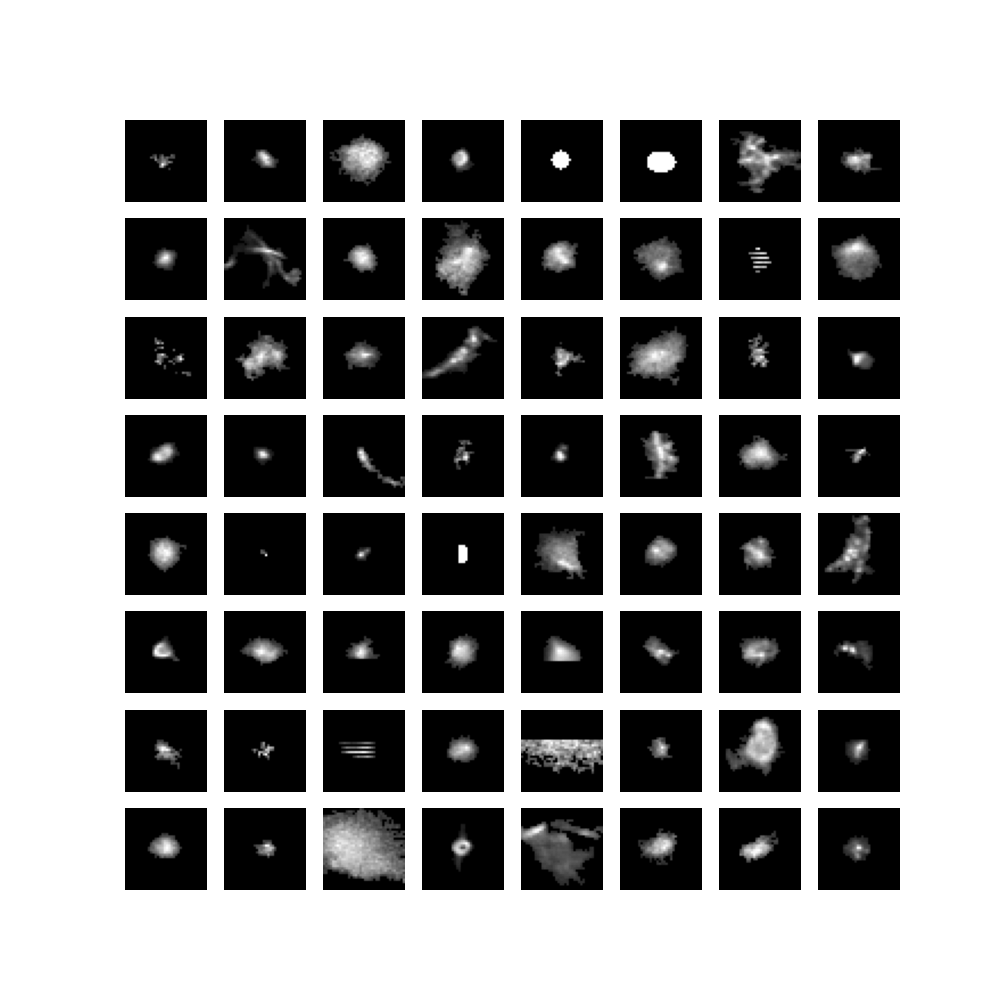

In [99]:
%matplotlib notebook
plotting_helpers.plot_image_grid(
    images=sf_concat_all[np.random.randint(0, sf_concat_all.shape[0], size=1000)],
#     images=sf_concat_rs[1636486:1730000],
#                                 labels=SYTlabels[20000:],
    grid_shape=(8,8),
    show_axis='off',
    cmap='gray',
    kwargs_subplots={'figsize':(10,10)},
    kwargs_imshow={'interpolation':'antialiased'});

## Saving

In [100]:
misc.estimate_array_size(sf_concat_all)

0.17234208

In [101]:
import scipy.sparse
import sparse

In [102]:
sf_concat_all_sparse = scipy.sparse.csr_matrix(sf_concat_all.reshape(sf_concat_all.shape[0],-1))

In [109]:
scipy.sparse.save_npz('/media/rich/bigSSD/other lab data/Takesian_lab/sf_concat_all_sparse.npz', sf_concat_all_sparse)

In [104]:
test = scipy.sparse.load_npz('/media/rich/bigSSD/other lab data/Takesian_lab/sf_concat_all_sparse.npz')

In [110]:
test.shape

(33245, 1296)

<IPython.core.display.Javascript object>


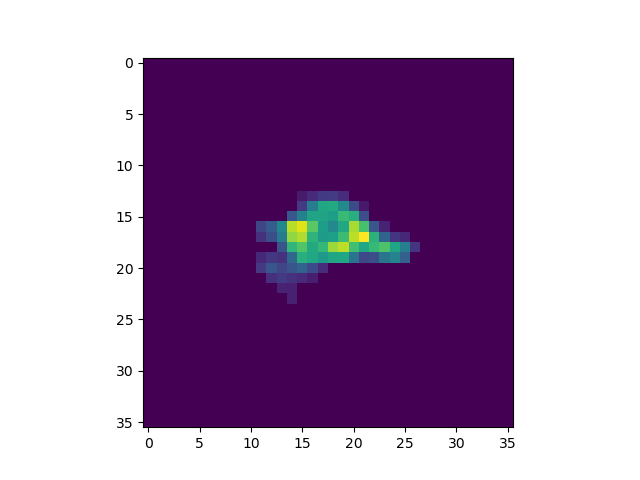

In [108]:
plt.figure()
plt.imshow(test[100].toarray().reshape(36,36))